<center><h1>ARIMA TRAINING</h1><center>


=== ARIMA Forecast for: POP ===
ADF p-value: 0.1484
 → Non-stationary, applying differencing.
Forecast (2025–2029):
17    82.831819
18    81.874830
19    81.452436
20    81.266001
21    81.183712
Name: predicted_mean, dtype: float64


c:\Users\jonaz\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\jonaz\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\jonaz\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\jonaz\AppData\Local\Programs\Python\Python313\Lib

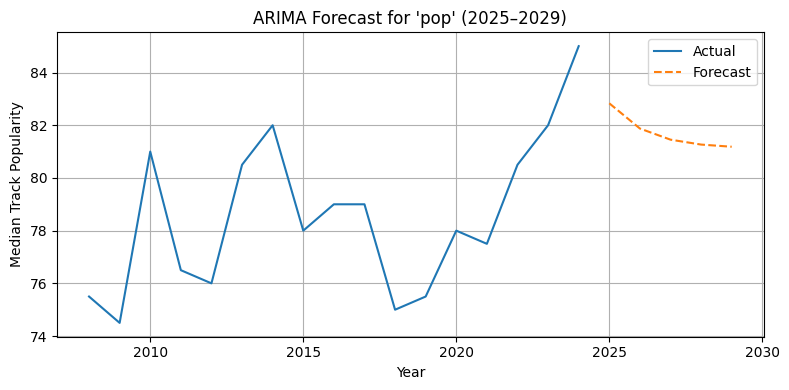

c:\Users\jonaz\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


MAE: 2.38 | RMSE: 2.81

=== ARIMA Forecast for: HIP-HOP ===
ADF p-value: 0.0000
Forecast (2025–2029):
14    71.764995
15    72.049664
16    71.984048
17    71.999172
18    71.995686
Name: predicted_mean, dtype: float64


c:\Users\jonaz\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\jonaz\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\jonaz\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\jonaz\AppData\Local\Programs\Python\Python313\Lib

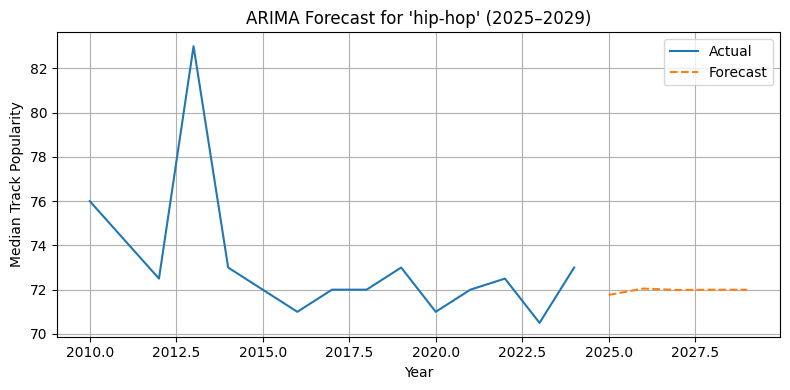

c:\Users\jonaz\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


MAE: 1.25 | RMSE: 1.27

=== ARIMA Forecast for: LATIN ===
ADF p-value: 0.3505
 → Non-stationary, applying differencing.


c:\Users\jonaz\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\jonaz\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\jonaz\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\jonaz\AppData\Local\Programs\Python\Python313\Lib

Forecast (2025–2029):
12    74.916803
13    73.527263
14    73.054394
15    72.893473
16    72.838710
Name: predicted_mean, dtype: float64


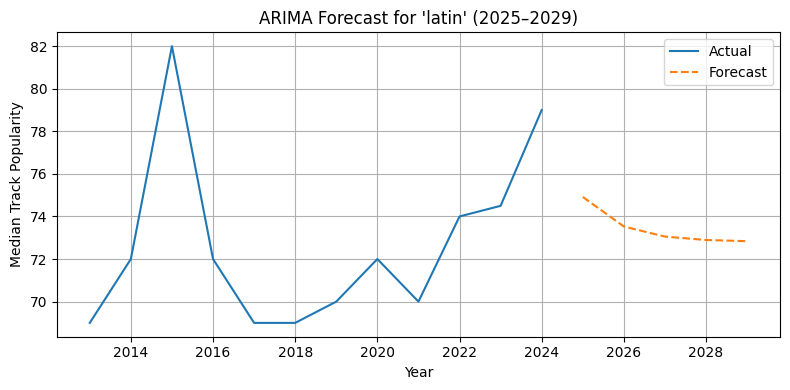

c:\Users\jonaz\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\jonaz\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\jonaz\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\jonaz\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.p

MAE: 3.94 | RMSE: 4.54

=== ARIMA Forecast for: ELECTRONIC ===
ADF p-value: 0.2126
 → Non-stationary, applying differencing.
Forecast (2025–2029):
16    71.572641
17    72.124965
18    72.318946
19    72.387073
20    72.411000
Name: predicted_mean, dtype: float64


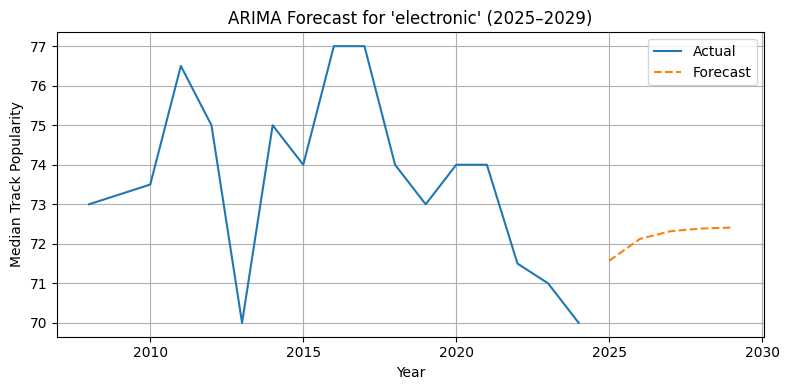

c:\Users\jonaz\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


MAE: 1.92 | RMSE: 1.99


In [16]:
genres = ['pop', 'hip-hop', 'latin', 'electronic']

for genre in genres:
    print(f"\n=== ARIMA Forecast for: {genre.upper()} ===")

    df_genre = df[df['playlist_genre'] == genre].sort_values('track_album_release_date')
    ts = df_genre.set_index('track_album_release_date')['median_track_popularity']

    # ADF Test for stationarity
    adf_result = adfuller(ts)
    print(f"ADF p-value: {adf_result[1]:.4f}")
    if adf_result[1] > 0.05:
        print(" → Non-stationary, applying differencing.")
        ts_diff = ts.diff().dropna()
    else:
        ts_diff = ts

    # Fit ARIMA
    model = ARIMA(ts, order=(1, 1, 1))
    model_fit = model.fit()

    # Forecast for 2025–2029
    forecast = model_fit.forecast(steps=5)
    print("Forecast (2025–2029):")
    print(forecast)

    # Plot
    plt.figure(figsize=(8, 4))
    plt.plot(ts, label='Actual')
    plt.plot(range(ts.index.max()+1, ts.index.max()+6), forecast, label='Forecast', linestyle='--')
    plt.title(f"ARIMA Forecast for '{genre}' (2025–2029)")
    plt.xlabel("Year")
    plt.ylabel("Median Track Popularity")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Optional: Evaluate if last 2 years available
    if ts.index.max() >= 2024:
        y_true = ts[-2:]
        y_pred = model_fit.predict(start=y_true.index[0], end=y_true.index[-1])
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        print(f"MAE: {mae:.2f} | RMSE: {rmse:.2f}")
